In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display

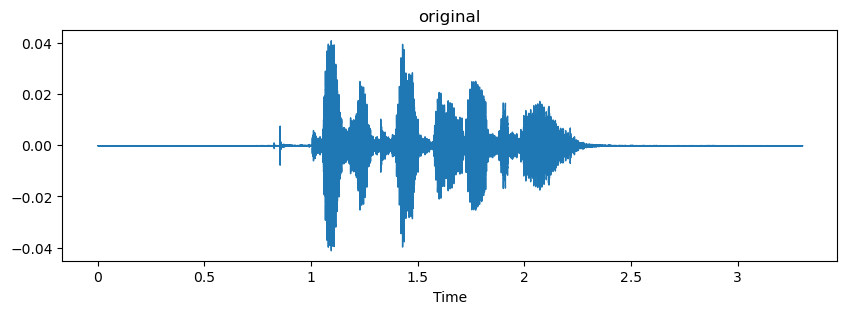

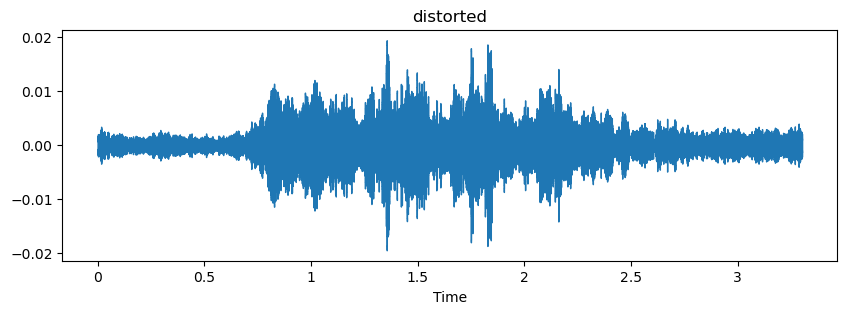

True


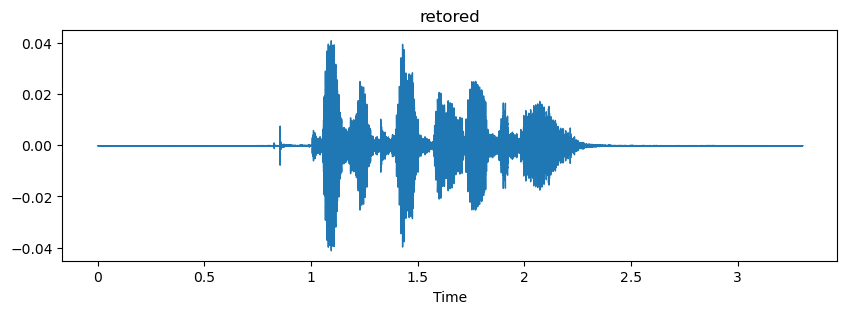

In [2]:
# Signal Scrambler
def distort_signal(y, sr, seed=42):
    np.random.seed(seed)
    Y= np.fft.fft(y)
    magnitude= np.abs(Y)

    values = np.linspace(-len(Y)/2, len(Y)/2, len(Y))

    # phase scale generatore (modified from sigmoid)
    def sigmoid(x):
        return x / (1 + np.exp(-x*x))

    sigmoid_vals= sigmoid(values) * sigmoid(values)

    rand_phase= np.exp(1j * 2 * np.pi * sigmoid_vals)

    # rand_phase = np.exp(1j * 2 * np.pi * np.random.rand(len(Y)))

    # Key to un-scrablem
    distortion_key= 1 / rand_phase

    Y_distorted= Y * rand_phase
    y_distorted= np.fft.ifft(Y_distorted)  # complex part is kept to un-scrablem the data

    return y_distorted, distortion_key

# Signal Unscrambler
def restore_signal(y_distorted, distortion_key):
    Y_distorted= np.fft.fft(y_distorted)  # Still complex
    Y_original= Y_distorted * distortion_key
    y_restored= np.fft.ifft(Y_original)
    return y_restored

# load signal
file_path= "Audio files/test.wav"
y, sr= librosa.load(file_path)

display(Audio(data=y, rate=sr))

plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("original")
plt.show()

# distort the signal
y_, key= distort_signal(y, sr, seed=42)

display(Audio(data=np.real(y_), rate=sr))

plt.figure(figsize=(10, 3))
librosa.display.waveshow(np.real(y_), sr=sr)
plt.title("distorted")
plt.show()

# restrore the signal
y__= restore_signal(y_, key)
print(np.allclose(y, y__, atol=1e-6))  # Should be True

display(Audio(data=np.real(y__), rate=sr))

plt.figure(figsize=(10, 3))
librosa.display.waveshow(np.real(y__), sr=sr)
plt.title("retored")
plt.show()

In [12]:
print(y.shape)
print(y_.shape)

(72838,)
(72838,)


## Audio Encryptor

In [11]:
import sounddevice as sd
import soundfile as sf
import numpy as np
import threading

In [26]:
def encrypt(y, sr):

    Y= np.fft.fft(y)
    magnitude= np.abs(Y)

    values= np.linspace(-len(Y)/2, len(Y)/2, len(Y))

    # phase scale generatore (modified from sigmoid)
    def sigmoid(x):
        return x / (1 + np.exp(-x*x))

    sigmoid_vals= sigmoid(values) * sigmoid(values)

    rand_phase= np.exp(1j * 2 * np.pi * sigmoid_vals)

    Y_distorted= Y * rand_phase
    y_distorted= np.fft.ifft(Y_distorted)  # complex part is kept to un-scrablem the data

    return y_distorted

def decrypt(y_distorted):

    values = np.linspace(-len(y_distorted)/2, len(y_distorted)/2, len(y_distorted))

    # phase scale generatore (modified from sigmoid)
    def sigmoid(x):
        return x / (1 + np.exp(-x*x))

    sigmoid_vals= sigmoid(values) * sigmoid(values)

    rand_phase= np.exp(1j * 2 * np.pi * sigmoid_vals)

    # Key to un-scrablem
    distortion_key= 1 / rand_phase
    Y_distorted= np.fft.fft(y_distorted)  # Still complex
    Y_original= Y_distorted * distortion_key
    y_restored= np.fft.ifft(Y_original)

    return y_restored

In [39]:
def callback(indata, frames, time, status):
    recorded_data.append(indata.copy())

# Start recording in a separate thread
def record_until_enter():
    print("🎤 Recording... Press Enter to stop.")
    with sd.InputStream(samplerate=samplerate, channels=channels, callback=callback):
        input()  # Wait for Enter
    print("Recording stopped.")

In [40]:
samplerate= 44100
channels= 1
filename= 'note.wav'

# Storage buffer
recorded_data= []

# Run the recording function
record_until_enter()

# Combine and save audio
audio_array=[]
audio_array= np.concatenate(recorded_data, axis=0)

t=[]
t= audio_array.reshape((audio_array.shape[0],))

sf.write(filename, t, samplerate)

🎤 Recording... Press Enter to stop.
Recording stopped.


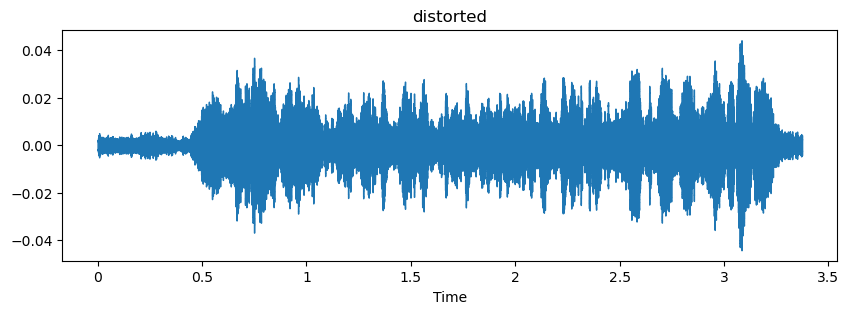

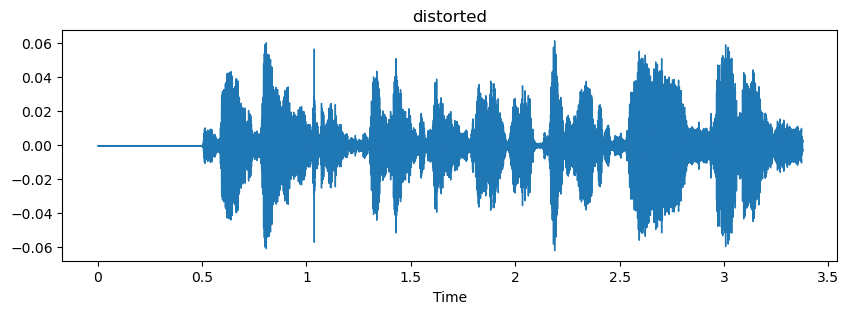

In [41]:
f_enc= encrypt(t, samplerate)

display(Audio(data=np.real(f_enc), rate=samplerate))

plt.figure(figsize=(10, 3))
librosa.display.waveshow(np.real(f_enc), sr=samplerate)
plt.title("distorted")
plt.show()

f_den= decrypt(f_enc)

display(Audio(data=np.real(f_den), rate=samplerate))

plt.figure(figsize=(10, 3))
librosa.display.waveshow(np.real(f_den), sr=samplerate)
plt.title("distorted")
plt.show()